In [ ]:

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
!pip install timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

try:
    import os, sys

    kernel_path = os.path.abspath(os.path.join('..'))
    sys.path.append(kernel_path)
    from kernels.window_process.window_process import WindowProcess, WindowProcessReverse

except:
    WindowProcess = None
    WindowProcessReverse = None
    print("[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.")


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 fused_window_process=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)
        self.fused_window_process = fused_window_process

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            if not self.fused_window_process:
                shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
                # partition windows
                x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
            else:
                x_windows = WindowProcess.apply(x, B, H, W, C, -self.shift_size, self.window_size)
        else:
            shifted_x = x
            # partition windows
            x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C

        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            if not self.fused_window_process:
                shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
                x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
            else:
                x = WindowProcessReverse.apply(attn_windows, B, H, W, C, self.shift_size, self.window_size)
        else:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)

        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 fused_window_process=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,
                                 fused_window_process=fused_window_process)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, fused_window_process=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint,
                               fused_window_process=fused_window_process)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 4.9 MB/s 
     |████████████████████████████████| 182 kB 84.3 MB/s 
[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving jaffe.zip to jaffe.zip


In [ ]:
model = SwinTransformer()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['jaffe.zip']), "r")
zf.extractall()

# New Section

In [ ]:
import cv2
img = cv2.imread('./jaffe/train/angry/KA.AN1.39.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
import numpy as np
img = np.expand_dims(img, -1)
print(img.shape)

(256, 256, 1)


In [ ]:
import torch
import torchvision
from torchvision import transforms
#import torchvision.transforms as T
from torch.utils.data import DataLoader
transform_trans=transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.ToTensor()])

#dataset
training_data = "./jaffe/train"
train_data= torchvision.datasets.ImageFolder(root=training_data,transform=transform_trans)

testing_set = "./jaffe/test"
test_data= torchvision.datasets.ImageFolder(root=testing_set,transform=transform_trans)

In [ ]:
batch_size=20
train_data_loader= torch.utils.data.DataLoader(train_data,batch_size=batch_size)
test_data_loader= torch.utils.data.DataLoader(test_data,batch_size=batch_size)


In [ ]:
from torch.cuda import device_of
from torch.optim import optimizer
from torch.nn.modules.loss import CrossEntropyLoss
import torch
from tqdm import tqdm
optim = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = CrossEntropyLoss()
total_epochs=100
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
for epoch in tqdm(range(total_epochs), desc="Training"):
  train_loss=0.0
  for batch in tqdm(train_data_loader,desc=f"Epoch {epoch +1} in training",leave=False):
    x,y = batch
    x,y= x.to(device), y.to(device)
    y_hat=model(x)
    print(y)
    loss= criterion(y_hat,y)

    train_loss+=loss.detach().cpu().item()/ len(train_data_loader)
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(f"epoch {epoch+1}/{total_epochs} loss: {train_loss:.2f}")

  

Epoch 1 in training:   9%|▉         | 1/11 [00:00<00:01,  6.49it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 1/100 loss: 0.47
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 1 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.56it/s]

epoch 1/100 loss: 1.65
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 1/100 loss: 3.17



Epoch 1 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.93it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 1/100 loss: 3.89
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 1/100 loss: 4.36



Epoch 1 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.95it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 1/100 loss: 4.64
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 1/100 loss: 5.19



Epoch 1 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.02it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 1/100 loss: 5.88
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 1 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.99it/s]

epoch 1/100 loss: 6.41
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 1/100 loss: 6.96
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:   1%|          | 1/100 [00:01<02:33,  1.55s/it]

epoch 1/100 loss: 7.25



Epoch 2 in training:   9%|▉         | 1/11 [00:00<00:01,  7.46it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 2/100 loss: 0.81



Epoch 2 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.35it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 2/100 loss: 1.74



Epoch 2 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.28it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 2/100 loss: 2.97



Epoch 2 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.24it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 2/100 loss: 3.69



Epoch 2 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.18it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 2/100 loss: 4.40



Epoch 2 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.18it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 2/100 loss: 5.07
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 2 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.04it/s]

epoch 2/100 loss: 5.55
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 2 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.96it/s]

epoch 2/100 loss: 5.87



Epoch 2 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.03it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 2/100 loss: 6.13
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:   2%|▏         | 2/100 [00:03<02:29,  1.53s/it]

epoch 2/100 loss: 6.63
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 2/100 loss: 7.10



Epoch 3 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 3 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.07it/s]

epoch 3/100 loss: 0.44
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 3/100 loss: 0.85



Epoch 3 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.11it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 3/100 loss: 1.18
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 3 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.04it/s]

epoch 3/100 loss: 1.46
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 3/100 loss: 1.67



Epoch 3 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.12it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 3/100 loss: 1.83
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 3/100 loss: 2.11



Epoch 3 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.15it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 3/100 loss: 2.44
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 3 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.90it/s]

epoch 3/100 loss: 2.76
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 3/100 loss: 2.94



Training:   3%|▎         | 3/100 [00:04<02:28,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 3/100 loss: 3.09



Epoch 4 in training:   9%|▉         | 1/11 [00:00<00:01,  7.33it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 4/100 loss: 0.38
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 4 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.92it/s]

epoch 4/100 loss: 0.71
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 4/100 loss: 1.00



Epoch 4 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.82it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 4/100 loss: 1.25
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 4 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.72it/s]

epoch 4/100 loss: 1.55
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 4/100 loss: 1.87



Epoch 4 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.38it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 4/100 loss: 2.11
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 4 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.49it/s]

epoch 4/100 loss: 2.34
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 4/100 loss: 2.58



Training:   4%|▍         | 4/100 [00:06<02:30,  1.57s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 4/100 loss: 2.89
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 4/100 loss: 3.17



Epoch 5 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.27it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 5/100 loss: 0.20
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 5/100 loss: 0.41



Epoch 5 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.06it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 5/100 loss: 0.63
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 5/100 loss: 0.87



Epoch 5 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.04it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 5/100 loss: 1.07
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 5/100 loss: 1.26



Epoch 5 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.15it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 5/100 loss: 1.52
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 5/100 loss: 1.78



Epoch 5 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.20it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 5/100 loss: 2.05
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 5/100 loss: 2.24



Training:   5%|▌         | 5/100 [00:07<02:26,  1.54s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 5/100 loss: 2.43



Epoch 6 in training:   9%|▉         | 1/11 [00:00<00:01,  7.53it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 6/100 loss: 0.27



Epoch 6 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.31it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 6/100 loss: 0.53



Epoch 6 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.23it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 6/100 loss: 0.79



Epoch 6 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.21it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 6/100 loss: 1.04



Epoch 6 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.22it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 6/100 loss: 1.30



Epoch 6 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.22it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 6/100 loss: 1.57



Epoch 6 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.20it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 6/100 loss: 1.80



Epoch 6 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.21it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 6/100 loss: 2.00



Epoch 6 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.20it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 6/100 loss: 2.20
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:   6%|▌         | 6/100 [00:09<02:23,  1.53s/it]

epoch 6/100 loss: 2.44
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 6/100 loss: 2.68



Epoch 7 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 7 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.07it/s]

epoch 7/100 loss: 0.22
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 7/100 loss: 0.43



Epoch 7 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.20it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 7/100 loss: 0.66
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 7/100 loss: 0.89



Epoch 7 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.14it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 7/100 loss: 1.09
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 7/100 loss: 1.30



Epoch 7 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.16it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 7/100 loss: 1.54
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 7 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.94it/s]

epoch 7/100 loss: 1.77
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 7/100 loss: 2.01



Training:   7%|▋         | 7/100 [00:10<02:22,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 7/100 loss: 2.22
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 7/100 loss: 2.41



Epoch 8 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.24it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 8/100 loss: 0.22
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 8/100 loss: 0.46



Epoch 8 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.23it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 8/100 loss: 0.72
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 8/100 loss: 0.96



Epoch 8 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.03it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 8/100 loss: 1.19
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 8 in training:  64%|██████▎   | 7/11 [00:00<00:00,  6.89it/s]

epoch 8/100 loss: 1.43
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 8/100 loss: 1.65



Epoch 8 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.03it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 8/100 loss: 1.87
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 8/100 loss: 2.08



Training:   8%|▊         | 8/100 [00:12<02:20,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 8/100 loss: 2.30
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 8/100 loss: 2.52



Epoch 9 in training:   9%|▉         | 1/11 [00:00<00:01,  6.96it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 9/100 loss: 0.22
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 9 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.80it/s]

epoch 9/100 loss: 0.42
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 9/100 loss: 0.65



Epoch 9 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.05it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 9/100 loss: 0.90
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 9/100 loss: 1.12



Epoch 9 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.16it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 9/100 loss: 1.34
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 9/100 loss: 1.57



Epoch 9 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.19it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 9/100 loss: 1.80
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 9/100 loss: 2.07



Training:   9%|▉         | 9/100 [00:13<02:18,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 9/100 loss: 2.28
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 9/100 loss: 2.48



Epoch 10 in training:   9%|▉         | 1/11 [00:00<00:01,  7.00it/s]


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 10/100 loss: 0.21
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 10/100 loss: 0.42


Epoch 10 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.83it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 10/100 loss: 0.66
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 10 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.94it/s]

epoch 10/100 loss: 0.88
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 10/100 loss: 1.09



Epoch 10 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.11it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 10/100 loss: 1.30
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 10/100 loss: 1.51



Epoch 10 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.21it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 10/100 loss: 1.73
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 10/100 loss: 1.92



Training:  10%|█         | 10/100 [00:15<02:17,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 10/100 loss: 2.14
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 10/100 loss: 2.36



Epoch 11 in training:   9%|▉         | 1/11 [00:00<00:01,  7.36it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 11/100 loss: 0.22
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 11 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.12it/s]

epoch 11/100 loss: 0.45
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 11/100 loss: 0.69



Epoch 11 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.07it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 11/100 loss: 0.93
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 11/100 loss: 1.15



Epoch 11 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.17it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 11/100 loss: 1.37
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 11/100 loss: 1.59



Epoch 11 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.17it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 11/100 loss: 1.82
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 11 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.08it/s]

epoch 11/100 loss: 2.03
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 11/100 loss: 2.22
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  11%|█         | 11/100 [00:16<02:15,  1.52s/it]

epoch 11/100 loss: 2.40



Epoch 12 in training:   9%|▉         | 1/11 [00:00<00:01,  7.43it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 12/100 loss: 0.20
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 12 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.14it/s]

epoch 12/100 loss: 0.42
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 12/100 loss: 0.64



Epoch 12 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.07it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 12/100 loss: 0.86
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 12/100 loss: 1.08



Epoch 12 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.04it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 12/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 12/100 loss: 1.52



Epoch 12 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.06it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 12/100 loss: 1.73
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 12/100 loss: 1.94



Training:  12%|█▏        | 12/100 [00:18<02:13,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 12/100 loss: 2.15
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 12/100 loss: 2.34



Epoch 13 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.30it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 13/100 loss: 0.20
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 13/100 loss: 0.40



Epoch 13 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.26it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 13/100 loss: 0.62
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 13/100 loss: 0.85



Epoch 13 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.25it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 13/100 loss: 1.06
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 13/100 loss: 1.27



Epoch 13 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.24it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 13/100 loss: 1.49
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 13 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.01it/s]

epoch 13/100 loss: 1.72
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 13/100 loss: 1.95



Training:  13%|█▎        | 13/100 [00:19<02:11,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 13/100 loss: 2.15
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 13/100 loss: 2.34



Epoch 14 in training:   9%|▉         | 1/11 [00:00<00:01,  6.97it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 14/100 loss: 0.23
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 14 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.03it/s]

epoch 14/100 loss: 0.45
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 14/100 loss: 0.68



Epoch 14 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.17it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 14/100 loss: 0.92
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 14/100 loss: 1.13



Epoch 14 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.11it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 14/100 loss: 1.33
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 14/100 loss: 1.57



Epoch 14 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.15it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 14/100 loss: 1.78
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 14 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.10it/s]

epoch 14/100 loss: 1.98
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 14/100 loss: 2.16
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  14%|█▍        | 14/100 [00:21<02:10,  1.51s/it]

epoch 14/100 loss: 2.33



Epoch 15 in training:   9%|▉         | 1/11 [00:00<00:01,  7.23it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 15/100 loss: 0.20



Epoch 15 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.26it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 15/100 loss: 0.41



Epoch 15 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.23it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 15/100 loss: 0.63



Epoch 15 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.22it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 15/100 loss: 0.87



Epoch 15 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.19it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 15/100 loss: 1.08



Epoch 15 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.19it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 15/100 loss: 1.29



Epoch 15 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.20it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 15/100 loss: 1.49



Epoch 15 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.22it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 15/100 loss: 1.72



Epoch 15 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.17it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 15/100 loss: 1.95
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  15%|█▌        | 15/100 [00:22<02:08,  1.51s/it]

epoch 15/100 loss: 2.16
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 15/100 loss: 2.35



Epoch 16 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 16 in training:   9%|▉         | 1/11 [00:00<00:01,  7.49it/s]

epoch 16/100 loss: 0.21
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 16 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.91it/s]

epoch 16/100 loss: 0.42



Epoch 16 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.86it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 16/100 loss: 0.64



Epoch 16 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.97it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 16/100 loss: 0.83



Epoch 16 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.04it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 16/100 loss: 1.03
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 16 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.02it/s]

epoch 16/100 loss: 1.25
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 16/100 loss: 1.47



Epoch 16 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.91it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 16/100 loss: 1.67
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 16 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.84it/s]

epoch 16/100 loss: 1.85
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 16/100 loss: 2.05
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  16%|█▌        | 16/100 [00:24<02:07,  1.52s/it]

epoch 16/100 loss: 2.24



Epoch 17 in training:   9%|▉         | 1/11 [00:00<00:01,  7.01it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 17/100 loss: 0.21



Epoch 17 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.17it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 17/100 loss: 0.42



Epoch 17 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.18it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 17/100 loss: 0.62



Epoch 17 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.22it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 17/100 loss: 0.86



Epoch 17 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.24it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 17/100 loss: 1.07



Epoch 17 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.24it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 17/100 loss: 1.27



Epoch 17 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.23it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 17/100 loss: 1.46



Epoch 17 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.23it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 17/100 loss: 1.67



Epoch 17 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.24it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 17/100 loss: 1.89
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  17%|█▋        | 17/100 [00:25<02:05,  1.51s/it]

epoch 17/100 loss: 2.05
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 17/100 loss: 2.22



Epoch 18 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 18 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.36it/s]

epoch 18/100 loss: 0.21
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 18/100 loss: 0.40



Epoch 18 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.08it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 18/100 loss: 0.61
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 18 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.99it/s]

epoch 18/100 loss: 0.82
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 18/100 loss: 1.02



Epoch 18 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.18it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 18/100 loss: 1.22
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 18/100 loss: 1.45



Epoch 18 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.21it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 18/100 loss: 1.66
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 18/100 loss: 1.87



Training:  18%|█▊        | 18/100 [00:27<02:03,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 18/100 loss: 2.06
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 18/100 loss: 2.25



Epoch 19 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.21it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 19/100 loss: 0.21
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 19/100 loss: 0.42



Epoch 19 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.11it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 19/100 loss: 0.62
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 19/100 loss: 0.82



Epoch 19 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.16it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 19/100 loss: 1.02
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 19/100 loss: 1.21



Epoch 19 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.16it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 19/100 loss: 1.41
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 19 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.00it/s]

epoch 19/100 loss: 1.61
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 19/100 loss: 1.80



Training:  19%|█▉        | 19/100 [00:28<02:02,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 19/100 loss: 2.00
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 19/100 loss: 2.18



Epoch 20 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.37it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 20/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 20/100 loss: 0.39



Epoch 20 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.29it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 20/100 loss: 0.61
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 20/100 loss: 0.82



Epoch 20 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.27it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 20/100 loss: 1.03
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 20/100 loss: 1.23



Epoch 20 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.23it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 20/100 loss: 1.43
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 20/100 loss: 1.64



Epoch 20 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.14it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 20/100 loss: 1.84
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 20/100 loss: 2.00



Training:  20%|██        | 20/100 [00:30<02:00,  1.50s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 20/100 loss: 2.16



Epoch 21 in training:   9%|▉         | 1/11 [00:00<00:01,  7.31it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 21/100 loss: 0.20



Epoch 21 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.18it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 21/100 loss: 0.42



Epoch 21 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.17it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 21/100 loss: 0.64
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 21 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.08it/s]

epoch 21/100 loss: 0.86
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 21/100 loss: 1.05



Epoch 21 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.99it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 21/100 loss: 1.25
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 21 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.87it/s]

epoch 21/100 loss: 1.46
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 21/100 loss: 1.66



Epoch 21 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.94it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 21/100 loss: 1.86
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 21/100 loss: 2.03



Training:  21%|██        | 21/100 [00:31<01:59,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 21/100 loss: 2.21



Epoch 22 in training:   9%|▉         | 1/11 [00:00<00:01,  7.43it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 22/100 loss: 0.21



Epoch 22 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.33it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 22/100 loss: 0.40



Epoch 22 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.26it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 22/100 loss: 0.59



Epoch 22 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.17it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 22/100 loss: 0.79



Epoch 22 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.18it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 22/100 loss: 0.98
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 22 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.11it/s]

epoch 22/100 loss: 1.20
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 22/100 loss: 1.39



Epoch 22 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.01it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 22/100 loss: 1.58
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 22 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.83it/s]

epoch 22/100 loss: 1.77
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 22/100 loss: 1.96



Training:  22%|██▏       | 22/100 [00:33<01:58,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 22/100 loss: 2.14



Epoch 23 in training:   9%|▉         | 1/11 [00:00<00:01,  7.43it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 23/100 loss: 0.21



Epoch 23 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.33it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 23/100 loss: 0.40



Epoch 23 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.30it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 23/100 loss: 0.61
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 23 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.16it/s]

epoch 23/100 loss: 0.82
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 23/100 loss: 1.01



Epoch 23 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.22it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 23/100 loss: 1.20
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 23/100 loss: 1.40



Epoch 23 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 23/100 loss: 1.60
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 23/100 loss: 1.79



Training:  23%|██▎       | 23/100 [00:34<01:56,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 23/100 loss: 1.96
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 23/100 loss: 2.12



Epoch 24 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.14it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 24/100 loss: 0.20
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 24/100 loss: 0.41



Epoch 24 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.13it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 24/100 loss: 0.62
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 24 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.82it/s]

epoch 24/100 loss: 0.81
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 24/100 loss: 1.01



Epoch 24 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.00it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 24/100 loss: 1.20
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 24/100 loss: 1.41



Epoch 24 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 24/100 loss: 1.61
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 24/100 loss: 1.81



Training:  24%|██▍       | 24/100 [00:36<01:54,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 24/100 loss: 1.98
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 24/100 loss: 2.15



Epoch 25 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.32it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 25/100 loss: 0.21
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 25/100 loss: 0.41



Epoch 25 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.15it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 25/100 loss: 0.60
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 25/100 loss: 0.81



Epoch 25 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.20it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 25/100 loss: 1.01
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 25/100 loss: 1.20



Epoch 25 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.19it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 25/100 loss: 1.39
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 25 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.12it/s]

epoch 25/100 loss: 1.58
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 25/100 loss: 1.76



Training:  25%|██▌       | 25/100 [00:37<01:53,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 25/100 loss: 1.94
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 25/100 loss: 2.11



Epoch 26 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.32it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 26/100 loss: 0.20
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 26/100 loss: 0.41



Epoch 26 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.08it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 26/100 loss: 0.63
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 26/100 loss: 0.84



Epoch 26 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.14it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 26/100 loss: 1.03
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 26/100 loss: 1.23



Epoch 26 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.17it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 26/100 loss: 1.42
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 26/100 loss: 1.60



Epoch 26 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.20it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 26/100 loss: 1.79
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 26/100 loss: 1.96



Training:  26%|██▌       | 26/100 [00:39<01:51,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 26/100 loss: 2.13



Epoch 27 in training:   9%|▉         | 1/11 [00:00<00:01,  7.46it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 27/100 loss: 0.19



Epoch 27 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.33it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 27/100 loss: 0.38



Epoch 27 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.26it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 27/100 loss: 0.57



Epoch 27 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.25it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 27/100 loss: 0.76
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 27 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.11it/s]

epoch 27/100 loss: 0.95
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 27/100 loss: 1.15



Epoch 27 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.12it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 27/100 loss: 1.34
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 27 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.94it/s]

epoch 27/100 loss: 1.54
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 27/100 loss: 1.73



Training:  27%|██▋       | 27/100 [00:40<01:50,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 27/100 loss: 1.90
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 27/100 loss: 2.07



Epoch 28 in training:   9%|▉         | 1/11 [00:00<00:01,  7.51it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 28/100 loss: 0.20
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 28 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.94it/s]

epoch 28/100 loss: 0.38
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 28/100 loss: 0.57



Epoch 28 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.05it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 28/100 loss: 0.76
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 28/100 loss: 0.95



Epoch 28 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.06it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 28/100 loss: 1.15
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 28/100 loss: 1.34



Epoch 28 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.17it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 28/100 loss: 1.54
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 28/100 loss: 1.74



Training:  28%|██▊       | 28/100 [00:42<01:48,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 28/100 loss: 1.91
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 28/100 loss: 2.08



Epoch 29 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.18it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 29/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 29/100 loss: 0.39



Epoch 29 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.08it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 29/100 loss: 0.58
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 29/100 loss: 0.79



Epoch 29 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.94it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 29/100 loss: 0.97
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 29 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.88it/s]

epoch 29/100 loss: 1.16
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 29/100 loss: 1.35



Epoch 29 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.87it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 29/100 loss: 1.55
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 29/100 loss: 1.74



Training:  29%|██▉       | 29/100 [00:44<01:48,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 29/100 loss: 1.90
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 29/100 loss: 2.05



Epoch 30 in training:   9%|▉         | 1/11 [00:00<00:01,  6.89it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 30/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 30 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.96it/s]

epoch 30/100 loss: 0.39
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 30/100 loss: 0.59



Epoch 30 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.86it/s]


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 30/100 loss: 0.79
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 30/100 loss: 0.98


Epoch 30 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.09it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 30/100 loss: 1.17
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 30/100 loss: 1.36



Epoch 30 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.08it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 30/100 loss: 1.55
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 30/100 loss: 1.73



Training:  30%|███       | 30/100 [00:45<01:46,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 30/100 loss: 1.89
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 30/100 loss: 2.05



Epoch 31 in training:   9%|▉         | 1/11 [00:00<00:01,  6.91it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 31/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 31 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.02it/s]

epoch 31/100 loss: 0.38
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 31/100 loss: 0.57



Epoch 31 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.15it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 31/100 loss: 0.78
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 31/100 loss: 0.97



Epoch 31 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.13it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 31/100 loss: 1.16
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 31 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.07it/s]

epoch 31/100 loss: 1.34
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 31/100 loss: 1.52



Epoch 31 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.13it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 31/100 loss: 1.72
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 31/100 loss: 1.89



Training:  31%|███       | 31/100 [00:47<01:45,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 31/100 loss: 2.05



Epoch 32 in training:   9%|▉         | 1/11 [00:00<00:01,  7.34it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 32/100 loss: 0.19



Epoch 32 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.22it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 32/100 loss: 0.38
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 32 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.01it/s]

epoch 32/100 loss: 0.58
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 32/100 loss: 0.78



Epoch 32 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.05it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 32/100 loss: 0.97



Epoch 32 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.12it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 32/100 loss: 1.15



Epoch 32 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.18it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 32/100 loss: 1.34



Epoch 32 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.16it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 32/100 loss: 1.54



Epoch 32 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.19it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 32/100 loss: 1.73



Epoch 32 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.18it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 32/100 loss: 1.90



Training:  32%|███▏      | 32/100 [00:48<01:43,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 32/100 loss: 2.06



Epoch 33 in training:   9%|▉         | 1/11 [00:00<00:01,  7.00it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 33/100 loss: 0.19



Epoch 33 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.09it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 33/100 loss: 0.38
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 33 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.00it/s]

epoch 33/100 loss: 0.57
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 33/100 loss: 0.77



Epoch 33 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.92it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 33/100 loss: 0.95
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 33 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.87it/s]

epoch 33/100 loss: 1.13
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 33/100 loss: 1.33



Epoch 33 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.99it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 33/100 loss: 1.51
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 33 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.00it/s]

epoch 33/100 loss: 1.69
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 33/100 loss: 1.86
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  33%|███▎      | 33/100 [00:50<01:42,  1.52s/it]

epoch 33/100 loss: 2.02



Epoch 34 in training:   9%|▉         | 1/11 [00:00<00:01,  7.14it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 34/100 loss: 0.20



Epoch 34 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.12it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 34/100 loss: 0.39



Epoch 34 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.13it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 34/100 loss: 0.57
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 34 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.07it/s]

epoch 34/100 loss: 0.77
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 34/100 loss: 0.97



Epoch 34 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.02it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 34/100 loss: 1.17
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 34/100 loss: 1.37



Epoch 34 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.07it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 34/100 loss: 1.56
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 34 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.06it/s]

epoch 34/100 loss: 1.74
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 34/100 loss: 1.91
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  34%|███▍      | 34/100 [00:51<01:40,  1.52s/it]

epoch 34/100 loss: 2.07



Epoch 35 in training:   9%|▉         | 1/11 [00:00<00:01,  7.41it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 35/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 35 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.95it/s]

epoch 35/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 35 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.79it/s]

epoch 35/100 loss: 0.57



Epoch 35 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.80it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 35/100 loss: 0.76



Epoch 35 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.87it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 35/100 loss: 0.95



Epoch 35 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.94it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 35/100 loss: 1.14
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 35 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.02it/s]

epoch 35/100 loss: 1.32
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 35/100 loss: 1.52



Epoch 35 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.04it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 35/100 loss: 1.71
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 35/100 loss: 1.88



Training:  35%|███▌      | 35/100 [00:53<01:39,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 35/100 loss: 2.05



Epoch 36 in training:   9%|▉         | 1/11 [00:00<00:01,  7.34it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 36/100 loss: 0.19



Epoch 36 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.25it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 36/100 loss: 0.38



Epoch 36 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.26it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 36/100 loss: 0.58



Epoch 36 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.24it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 36/100 loss: 0.78



Epoch 36 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.20it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 36/100 loss: 0.96


tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 36/100 loss: 1.15


Epoch 36 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.13it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 36/100 loss: 1.33



Epoch 36 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.17it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 36/100 loss: 1.53



Epoch 36 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.16it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 36/100 loss: 1.72



Epoch 36 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.18it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 36/100 loss: 1.88



Training:  36%|███▌      | 36/100 [00:54<01:37,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 36/100 loss: 2.03



Epoch 37 in training:   9%|▉         | 1/11 [00:00<00:01,  7.00it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 37/100 loss: 0.19



Epoch 37 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.12it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 37/100 loss: 0.37



Epoch 37 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.11it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 37/100 loss: 0.57



Epoch 37 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.15it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 37/100 loss: 0.76



Epoch 37 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.17it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 37/100 loss: 0.95



Epoch 37 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.20it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 37/100 loss: 1.13



Epoch 37 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 37/100 loss: 1.32



Epoch 37 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.11it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 37/100 loss: 1.50
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 37 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.98it/s]

epoch 37/100 loss: 1.69
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Epoch 37 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.95it/s]

epoch 37/100 loss: 1.85
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  37%|███▋      | 37/100 [00:56<01:35,  1.52s/it]

epoch 37/100 loss: 2.02



Epoch 38 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 38 in training:   9%|▉         | 1/11 [00:00<00:01,  7.43it/s]

epoch 38/100 loss: 0.19



Epoch 38 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.25it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 38/100 loss: 0.38



Epoch 38 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.23it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 38/100 loss: 0.56



Epoch 38 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.21it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 38/100 loss: 0.76
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 38 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.06it/s]

epoch 38/100 loss: 0.95
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 38/100 loss: 1.14



Epoch 38 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.03it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 38/100 loss: 1.32
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 38/100 loss: 1.52



Epoch 38 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.12it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 38/100 loss: 1.70
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 38/100 loss: 1.87



Training:  38%|███▊      | 38/100 [00:57<01:33,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 38/100 loss: 2.04



Epoch 39 in training:   9%|▉         | 1/11 [00:00<00:01,  7.29it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 39/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 39 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.96it/s]


epoch 39/100 loss: 0.38
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 39/100 loss: 0.56


Epoch 39 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.97it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 39/100 loss: 0.75
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 39/100 loss: 0.94



Epoch 39 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.13it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 39/100 loss: 1.13
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 39/100 loss: 1.32



Epoch 39 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.15it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 39/100 loss: 1.52
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 39/100 loss: 1.71



Training:  39%|███▉      | 39/100 [00:59<01:32,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 39/100 loss: 1.87
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 39/100 loss: 2.03



Epoch 40 in training:   9%|▉         | 1/11 [00:00<00:01,  6.89it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 40/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 40 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.79it/s]

epoch 40/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 40/100 loss: 0.57



Epoch 40 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.94it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 40/100 loss: 0.76
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 40/100 loss: 0.94



Epoch 40 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.09it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 40/100 loss: 1.13
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 40/100 loss: 1.32



Epoch 40 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 40/100 loss: 1.51
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 40/100 loss: 1.69



Training:  40%|████      | 40/100 [01:00<01:31,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 40/100 loss: 1.85
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 40/100 loss: 2.01



Epoch 41 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.18it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 41/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 41/100 loss: 0.37



Epoch 41 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.17it/s]


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 41/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 41/100 loss: 0.76


Epoch 41 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.05it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 41/100 loss: 0.95
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 41/100 loss: 1.14



Epoch 41 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 41/100 loss: 1.33
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 41/100 loss: 1.51



Epoch 41 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.14it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 41/100 loss: 1.69
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  41%|████      | 41/100 [01:02<01:29,  1.52s/it]

epoch 41/100 loss: 1.85
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 41/100 loss: 2.01



Epoch 42 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 42 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.05it/s]

epoch 42/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 42/100 loss: 0.38



Epoch 42 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.93it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 42/100 loss: 0.57
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 42/100 loss: 0.76



Epoch 42 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.05it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 42/100 loss: 0.94
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 42/100 loss: 1.13



Epoch 42 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.12it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 42/100 loss: 1.31
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 42/100 loss: 1.50



Epoch 42 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.14it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 42/100 loss: 1.68
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 42/100 loss: 1.84



Training:  42%|████▏     | 42/100 [01:03<01:27,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 42/100 loss: 2.00



Epoch 43 in training:   9%|▉         | 1/11 [00:00<00:01,  7.05it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 43/100 loss: 0.19



Epoch 43 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.10it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 43/100 loss: 0.38
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 43 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.04it/s]

epoch 43/100 loss: 0.57
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 43/100 loss: 0.76



Epoch 43 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.10it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 43/100 loss: 0.94



Epoch 43 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.08it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 43/100 loss: 1.12



Epoch 43 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.10it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 43/100 loss: 1.30



Epoch 43 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.15it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 43/100 loss: 1.49



Epoch 43 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.16it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 43/100 loss: 1.68
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  43%|████▎     | 43/100 [01:05<01:26,  1.52s/it]

epoch 43/100 loss: 1.85
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 43/100 loss: 2.01



Epoch 44 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 44 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.19it/s]

epoch 44/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 44/100 loss: 0.37



Epoch 44 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.00it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 44/100 loss: 0.57
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 44/100 loss: 0.76



Epoch 44 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.13it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 44/100 loss: 0.94
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 44/100 loss: 1.12



Epoch 44 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 44/100 loss: 1.31
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 44/100 loss: 1.49



Epoch 44 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.14it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 44/100 loss: 1.67
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 44/100 loss: 1.84



Training:  44%|████▍     | 44/100 [01:06<01:24,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 44/100 loss: 2.00



Epoch 45 in training:   9%|▉         | 1/11 [00:00<00:01,  7.26it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 45/100 loss: 0.18



Epoch 45 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.21it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 45/100 loss: 0.37



Epoch 45 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.20it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 45/100 loss: 0.55



Epoch 45 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.21it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 45/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 45 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.00it/s]

epoch 45/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 45 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.89it/s]

epoch 45/100 loss: 1.10



Epoch 45 in training:  64%|██████▎   | 7/11 [00:00<00:00,  6.93it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 45/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 45 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.95it/s]

epoch 45/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 45/100 loss: 1.66



Training:  45%|████▌     | 45/100 [01:08<01:23,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 45/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 45/100 loss: 1.98



Epoch 46 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.16it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 46/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 46/100 loss: 0.37



Epoch 46 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.18it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 46/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 46/100 loss: 0.75



Epoch 46 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.20it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 46/100 loss: 0.94
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 46/100 loss: 1.12



Epoch 46 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.11it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 46/100 loss: 1.31
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 46/100 loss: 1.49



Epoch 46 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.21it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 46/100 loss: 1.66
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 46/100 loss: 1.83



Training:  46%|████▌     | 46/100 [01:09<01:21,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 46/100 loss: 2.00



Epoch 47 in training:   9%|▉         | 1/11 [00:00<00:01,  7.29it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 47/100 loss: 0.19



Epoch 47 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.24it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 47/100 loss: 0.38



Epoch 47 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.21it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 47/100 loss: 0.57



Epoch 47 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.17it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 47/100 loss: 0.76
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 47 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.03it/s]

epoch 47/100 loss: 0.95
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 47/100 loss: 1.13



Epoch 47 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.10it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 47/100 loss: 1.32
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 47 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.07it/s]

epoch 47/100 loss: 1.50
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 47/100 loss: 1.68



Training:  47%|████▋     | 47/100 [01:11<01:20,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 47/100 loss: 1.84
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 47/100 loss: 2.01



Epoch 48 in training:   9%|▉         | 1/11 [00:00<00:01,  6.99it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 48/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 48 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.81it/s]

epoch 48/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 48/100 loss: 0.55



Epoch 48 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.04it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 48/100 loss: 0.75
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 48/100 loss: 0.93



Epoch 48 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.15it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 48/100 loss: 1.11
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 48/100 loss: 1.29



Epoch 48 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 48/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 48/100 loss: 1.65



Training:  48%|████▊     | 48/100 [01:12<01:18,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 48/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 48/100 loss: 1.97



Epoch 49 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.32it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 49/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 49/100 loss: 0.38



Epoch 49 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.20it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 49/100 loss: 0.58
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 49/100 loss: 0.77



Epoch 49 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.21it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 49/100 loss: 0.95
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 49/100 loss: 1.13



Epoch 49 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.19it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 49/100 loss: 1.31
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 49/100 loss: 1.49



Epoch 49 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.13it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 49/100 loss: 1.68
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 49/100 loss: 1.84



Training:  49%|████▉     | 49/100 [01:14<01:16,  1.51s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 49/100 loss: 2.00



Epoch 50 in training:   9%|▉         | 1/11 [00:00<00:01,  7.46it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 50/100 loss: 0.18



Epoch 50 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.18it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 50/100 loss: 0.37



Epoch 50 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.17it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 50/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 50 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.05it/s]

epoch 50/100 loss: 0.76
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 50/100 loss: 0.94



Epoch 50 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.13it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 50/100 loss: 1.12
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 50/100 loss: 1.30



Epoch 50 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.12it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 50/100 loss: 1.49
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 50 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.94it/s]

epoch 50/100 loss: 1.67
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 50/100 loss: 1.83
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  50%|█████     | 50/100 [01:15<01:15,  1.51s/it]

epoch 50/100 loss: 1.98



Epoch 51 in training:   9%|▉         | 1/11 [00:00<00:01,  7.01it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 51/100 loss: 0.18



Epoch 51 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.04it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 51/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 51 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.93it/s]

epoch 51/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 51/100 loss: 0.75



Epoch 51 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.05it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 51/100 loss: 0.93
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 51/100 loss: 1.11



Epoch 51 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.16it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 51/100 loss: 1.30
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 51/100 loss: 1.49



Epoch 51 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.07it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 51/100 loss: 1.68
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 51/100 loss: 1.83



Training:  51%|█████     | 51/100 [01:17<01:14,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 51/100 loss: 2.00



Epoch 52 in training:   9%|▉         | 1/11 [00:00<00:01,  7.09it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 52/100 loss: 0.19



Epoch 52 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.15it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 52/100 loss: 0.37



Epoch 52 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.07it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 52/100 loss: 0.56



Epoch 52 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.07it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 52/100 loss: 0.75



Epoch 52 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.11it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 52/100 loss: 0.94



Epoch 52 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.12it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 52/100 loss: 1.12
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 52 in training:  64%|██████▎   | 7/11 [00:00<00:00,  6.99it/s]


epoch 52/100 loss: 1.31
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 52/100 loss: 1.49


Epoch 52 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.86it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 52/100 loss: 1.67
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  52%|█████▏    | 52/100 [01:18<01:12,  1.52s/it]

epoch 52/100 loss: 1.84
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 52/100 loss: 2.00



Epoch 53 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 53 in training:   9%|▉         | 1/11 [00:00<00:01,  6.82it/s]

epoch 53/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 53 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.78it/s]

epoch 53/100 loss: 0.37



Epoch 53 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.74it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 53/100 loss: 0.55


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 53/100 loss: 0.74


Epoch 53 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.81it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 53 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.79it/s]

epoch 53/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 53 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.81it/s]

epoch 53/100 loss: 1.10



Epoch 53 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.92it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 53/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 53 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.90it/s]

epoch 53/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 53 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.87it/s]

epoch 53/100 loss: 1.65



Epoch 53 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.85it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 53/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  53%|█████▎    | 53/100 [01:20<01:12,  1.53s/it]

epoch 53/100 loss: 1.98



Epoch 54 in training:   9%|▉         | 1/11 [00:00<00:01,  7.10it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 54/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 54 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.98it/s]

epoch 54/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 54 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.89it/s]

epoch 54/100 loss: 0.55



Epoch 54 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.97it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 54/100 loss: 0.74



Epoch 54 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.02it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 54/100 loss: 0.93



Epoch 54 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.08it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 54/100 loss: 1.11



Epoch 54 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.04it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 54/100 loss: 1.30


tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 54 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.91it/s]

epoch 54/100 loss: 1.48
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 54 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.85it/s]

epoch 54/100 loss: 1.67



Epoch 54 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.97it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 54/100 loss: 1.83
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  54%|█████▍    | 54/100 [01:22<01:10,  1.53s/it]

epoch 54/100 loss: 1.99



Epoch 55 in training:   9%|▉         | 1/11 [00:00<00:01,  7.34it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 55/100 loss: 0.18



Epoch 55 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.22it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 55/100 loss: 0.36



Epoch 55 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.19it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 55/100 loss: 0.55



Epoch 55 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.18it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 55/100 loss: 0.74



Epoch 55 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.12it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 55/100 loss: 0.92



Epoch 55 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.14it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 55/100 loss: 1.10



Epoch 55 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.15it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 55/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 55 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.05it/s]

epoch 55/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 55/100 loss: 1.65



Training:  55%|█████▌    | 55/100 [01:23<01:08,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 55/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 55/100 loss: 1.98



Epoch 56 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.20it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 56/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 56/100 loss: 0.36



Epoch 56 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.21it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 56/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 56 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.04it/s]

epoch 56/100 loss: 0.73
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 56/100 loss: 0.91



Epoch 56 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.08it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 56/100 loss: 1.09
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 56/100 loss: 1.28



Epoch 56 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.03it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 56/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 56/100 loss: 1.65



Training:  56%|█████▌    | 56/100 [01:25<01:06,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 56/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 56/100 loss: 1.97



Epoch 57 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.03it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 57/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 57/100 loss: 0.37



Epoch 57 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.15it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 57/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 57/100 loss: 0.74



Epoch 57 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.09it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 57/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 57/100 loss: 1.10



Epoch 57 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 57/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 57/100 loss: 1.47



Epoch 57 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.14it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 57/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  57%|█████▋    | 57/100 [01:26<01:05,  1.52s/it]

epoch 57/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 57/100 loss: 1.98



Epoch 58 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 58 in training:   9%|▉         | 1/11 [00:00<00:01,  6.91it/s]

epoch 58/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 58 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.74it/s]

epoch 58/100 loss: 0.37



Epoch 58 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.76it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 58/100 loss: 0.55


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 58/100 loss: 0.73


Epoch 58 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.82it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 58 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.77it/s]

epoch 58/100 loss: 0.91
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 58 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.72it/s]

epoch 58/100 loss: 1.09



Epoch 58 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.75it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 58/100 loss: 1.28



Epoch 58 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.86it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 58/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 58 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.81it/s]


epoch 58/100 loss: 1.64
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 58/100 loss: 1.80


Epoch 58 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.87it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  58%|█████▊    | 58/100 [01:28<01:04,  1.54s/it]

epoch 58/100 loss: 1.96



Epoch 59 in training:   9%|▉         | 1/11 [00:00<00:01,  7.38it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 59/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 59 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.97it/s]

epoch 59/100 loss: 0.36
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 59/100 loss: 0.55



Epoch 59 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.03it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 59/100 loss: 0.75
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 59/100 loss: 0.93



Epoch 59 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.13it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 59/100 loss: 1.11
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 59/100 loss: 1.30



Epoch 59 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.16it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 59/100 loss: 1.48
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 59/100 loss: 1.66



Training:  59%|█████▉    | 59/100 [01:29<01:02,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 59/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 59/100 loss: 1.98



Epoch 60 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.13it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 60/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 60/100 loss: 0.37



Epoch 60 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.90it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 60/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 60/100 loss: 0.75



Epoch 60 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.89it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 60/100 loss: 0.94
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 60/100 loss: 1.12



Epoch 60 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.99it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 60/100 loss: 1.30
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 60/100 loss: 1.49



Epoch 60 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.08it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 60/100 loss: 1.67
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 60/100 loss: 1.83



Training:  60%|██████    | 60/100 [01:31<01:01,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 60/100 loss: 1.99



Epoch 61 in training:   9%|▉         | 1/11 [00:00<00:01,  7.27it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 61/100 loss: 0.19



Epoch 61 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.14it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 61/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 61 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.07it/s]

epoch 61/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 61/100 loss: 0.75



Epoch 61 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.11it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 61/100 loss: 0.93
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 61/100 loss: 1.11



Epoch 61 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.12it/s]


tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 61/100 loss: 1.30
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 61/100 loss: 1.48


Epoch 61 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.15it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 61/100 loss: 1.66
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 61/100 loss: 1.81



Training:  61%|██████    | 61/100 [01:32<00:59,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 61/100 loss: 1.97



Epoch 62 in training:   9%|▉         | 1/11 [00:00<00:01,  7.07it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 62/100 loss: 0.18



Epoch 62 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.09it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 62/100 loss: 0.36



Epoch 62 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.10it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 62/100 loss: 0.55



Epoch 62 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.12it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 62/100 loss: 0.74



Epoch 62 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.06it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 62/100 loss: 0.93



Epoch 62 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.11it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 62/100 loss: 1.12



Epoch 62 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.11it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 62/100 loss: 1.30


tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 62/100 loss: 1.48


Epoch 62 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.10it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 62/100 loss: 1.67



Epoch 62 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.13it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 62/100 loss: 1.83



Training:  62%|██████▏   | 62/100 [01:34<00:57,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 62/100 loss: 2.00



Epoch 63 in training:   9%|▉         | 1/11 [00:00<00:01,  6.88it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 63/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 63 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.73it/s]

epoch 63/100 loss: 0.38
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 63 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.76it/s]

epoch 63/100 loss: 0.57



Epoch 63 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.85it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 63/100 loss: 0.76



Epoch 63 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.93it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 63/100 loss: 0.94
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 63 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.74it/s]


epoch 63/100 loss: 1.12
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 63/100 loss: 1.31


Epoch 63 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.93it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 63/100 loss: 1.49
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 63/100 loss: 1.67



Training:  63%|██████▎   | 63/100 [01:35<00:56,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 63/100 loss: 1.83
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 63/100 loss: 1.99



Epoch 64 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.30it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 64/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 64/100 loss: 0.36



Epoch 64 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.10it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 64/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 64/100 loss: 0.73



Epoch 64 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.18it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 64/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 64/100 loss: 1.10



Epoch 64 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.02it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 64/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 64 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.05it/s]

epoch 64/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 64/100 loss: 1.65



Training:  64%|██████▍   | 64/100 [01:37<00:54,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 64/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 64/100 loss: 1.98



Epoch 65 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.25it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 65/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 65/100 loss: 0.37



Epoch 65 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.24it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 65/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 65 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.03it/s]

epoch 65/100 loss: 0.75
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 65/100 loss: 0.93



Epoch 65 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.13it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 65/100 loss: 1.11
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 65/100 loss: 1.30



Epoch 65 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.16it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 65/100 loss: 1.48
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 65/100 loss: 1.66



Training:  65%|██████▌   | 65/100 [01:38<00:53,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 65/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 65/100 loss: 1.98



Epoch 66 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.26it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 66/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 66/100 loss: 0.37



Epoch 66 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.19it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 66/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 66/100 loss: 0.74



Epoch 66 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.13it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 66/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 66/100 loss: 1.10



Epoch 66 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.04it/s]


tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 66/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 66/100 loss: 1.46


Epoch 66 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.09it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 66/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 66/100 loss: 1.81



Training:  66%|██████▌   | 66/100 [01:40<00:51,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 66/100 loss: 1.98



Epoch 67 in training:   9%|▉         | 1/11 [00:00<00:01,  7.20it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 67/100 loss: 0.18



Epoch 67 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.06it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 67/100 loss: 0.37


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 67 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.02it/s]

epoch 67/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 67/100 loss: 0.74



Epoch 67 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.97it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 67/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 67/100 loss: 1.10



Epoch 67 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.04it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 67/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 67/100 loss: 1.47



Epoch 67 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.12it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 67/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 67/100 loss: 1.81



Training:  67%|██████▋   | 67/100 [01:41<00:50,  1.52s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 67/100 loss: 1.97



Epoch 68 in training:   9%|▉         | 1/11 [00:00<00:01,  7.31it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 68/100 loss: 0.19



Epoch 68 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.26it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 68/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 68 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.89it/s]

epoch 68/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 68 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.87it/s]

epoch 68/100 loss: 0.75



Epoch 68 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.88it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 68/100 loss: 0.93



Epoch 68 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.97it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 68/100 loss: 1.11



Epoch 68 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.01it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 68/100 loss: 1.30
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 68 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.91it/s]

epoch 68/100 loss: 1.48
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 68 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.87it/s]

epoch 68/100 loss: 1.66



Epoch 68 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.80it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 68/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  68%|██████▊   | 68/100 [01:43<00:48,  1.53s/it]

epoch 68/100 loss: 1.98



Epoch 69 in training:   9%|▉         | 1/11 [00:00<00:01,  7.31it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 69/100 loss: 0.18



Epoch 69 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.20it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 69/100 loss: 0.37


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 69/100 loss: 0.55


Epoch 69 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.06it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 69/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 69 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.01it/s]

epoch 69/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 69/100 loss: 1.10



Epoch 69 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.02it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 69/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 69 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.99it/s]

epoch 69/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 69/100 loss: 1.65



Training:  69%|██████▉   | 69/100 [01:44<00:47,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 69/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 69/100 loss: 1.97



Epoch 70 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.14it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 70/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 70/100 loss: 0.36



Epoch 70 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.10it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 70/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 70 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.96it/s]

epoch 70/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 70/100 loss: 0.92



Epoch 70 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.88it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 70/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 70 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.88it/s]

epoch 70/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 70/100 loss: 1.47



Epoch 70 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.95it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 70/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  70%|███████   | 70/100 [01:46<00:46,  1.54s/it]

epoch 70/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 70/100 loss: 1.97



Epoch 71 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 71 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.10it/s]

epoch 71/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 71/100 loss: 0.36



Epoch 71 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.07it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 71/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 71 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.04it/s]

epoch 71/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 71/100 loss: 0.92



Epoch 71 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.98it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 71/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 71 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.00it/s]

epoch 71/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 71/100 loss: 1.45



Epoch 71 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.94it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 71/100 loss: 1.64
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  71%|███████   | 71/100 [01:48<00:44,  1.54s/it]

epoch 71/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 71/100 loss: 1.95



Epoch 72 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 72 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.00it/s]

epoch 72/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 72/100 loss: 0.37



Epoch 72 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.95it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 72/100 loss: 0.56
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 72/100 loss: 0.75



Epoch 72 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.87it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 72/100 loss: 0.94
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 72 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.84it/s]

epoch 72/100 loss: 1.12
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 72/100 loss: 1.30



Epoch 72 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.95it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 72/100 loss: 1.48
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 72/100 loss: 1.67



Training:  72%|███████▏  | 72/100 [01:49<00:43,  1.54s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 72/100 loss: 1.83
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 72/100 loss: 2.00



Epoch 73 in training:   9%|▉         | 1/11 [00:00<00:01,  7.15it/s]


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 73/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 73/100 loss: 0.37


Epoch 73 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.11it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 73/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 73/100 loss: 0.74



Epoch 73 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.12it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 73/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 73/100 loss: 1.10



Epoch 73 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.13it/s]


tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 73/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 73/100 loss: 1.47


Epoch 73 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.09it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 73/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 73/100 loss: 1.81



Training:  73%|███████▎  | 73/100 [01:51<00:41,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 73/100 loss: 1.97



Epoch 74 in training:   9%|▉         | 1/11 [00:00<00:01,  6.96it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 74/100 loss: 0.18



Epoch 74 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.11it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 74/100 loss: 0.37



Epoch 74 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.09it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 74/100 loss: 0.55



Epoch 74 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.04it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 74/100 loss: 0.74



Epoch 74 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.09it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 74/100 loss: 0.93



Epoch 74 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.12it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 74/100 loss: 1.12



Epoch 74 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.13it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 74/100 loss: 1.30



Epoch 74 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.07it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 74/100 loss: 1.48


tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 74 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.93it/s]

epoch 74/100 loss: 1.66
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Epoch 74 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.85it/s]

epoch 74/100 loss: 1.83
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  74%|███████▍  | 74/100 [01:52<00:39,  1.53s/it]

epoch 74/100 loss: 1.98



Epoch 75 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 75 in training:   9%|▉         | 1/11 [00:00<00:01,  6.91it/s]

epoch 75/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 75 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.77it/s]

epoch 75/100 loss: 0.36


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 75/100 loss: 0.55


Epoch 75 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.96it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 75/100 loss: 0.74



Epoch 75 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.01it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 75/100 loss: 0.92



Epoch 75 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.01it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 75/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 75 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.92it/s]

epoch 75/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 75 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.84it/s]

epoch 75/100 loss: 1.46



Epoch 75 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.95it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 75/100 loss: 1.64



Epoch 75 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.04it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 75/100 loss: 1.81



Training:  75%|███████▌  | 75/100 [01:54<00:38,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 75/100 loss: 1.97



Epoch 76 in training:   9%|▉         | 1/11 [00:00<00:01,  6.85it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 76/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 76 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.98it/s]

epoch 76/100 loss: 0.36
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 76/100 loss: 0.55



Epoch 76 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.12it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 76/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 76/100 loss: 0.92



Epoch 76 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.17it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 76/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 76/100 loss: 1.28



Epoch 76 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.12it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 76/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 76/100 loss: 1.64



Training:  76%|███████▌  | 76/100 [01:55<00:36,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 76/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 76/100 loss: 1.96



Epoch 77 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.21it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 77/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 77/100 loss: 0.37



Epoch 77 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.09it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 77/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 77 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.04it/s]

epoch 77/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 77/100 loss: 0.92



Epoch 77 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.08it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 77/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 77/100 loss: 1.28



Epoch 77 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.01it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 77/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 77 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.86it/s]

epoch 77/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 77/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  77%|███████▋  | 77/100 [01:57<00:35,  1.53s/it]

epoch 77/100 loss: 1.96



Epoch 78 in training:   9%|▉         | 1/11 [00:00<00:01,  6.98it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 78/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 78 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.00it/s]

epoch 78/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 78/100 loss: 0.55



Epoch 78 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.05it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 78/100 loss: 0.73
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 78/100 loss: 0.92



Epoch 78 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.04it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 78/100 loss: 1.09
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 78/100 loss: 1.28



Epoch 78 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.09it/s]


tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 78/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 78/100 loss: 1.64


Training:  78%|███████▊  | 78/100 [01:58<00:33,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 78/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 78/100 loss: 1.96



Epoch 79 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.16it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 79/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 79/100 loss: 0.36



Epoch 79 in training:  27%|██▋       | 3/11 [00:00<00:01,  7.10it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 79/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 79/100 loss: 0.74



Epoch 79 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.91it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 79/100 loss: 0.93
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 79/100 loss: 1.11



Epoch 79 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.95it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 79/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 79/100 loss: 1.47



Epoch 79 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.99it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 79/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 79/100 loss: 1.81



Training:  79%|███████▉  | 79/100 [02:00<00:32,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 79/100 loss: 1.97



Epoch 80 in training:   9%|▉         | 1/11 [00:00<00:01,  7.01it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 80/100 loss: 0.19
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 80 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.89it/s]

epoch 80/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 80 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.68it/s]

epoch 80/100 loss: 0.55



Epoch 80 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.86it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 80/100 loss: 0.74



Epoch 80 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.97it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 80/100 loss: 0.92



Epoch 80 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.02it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 80/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 80 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.93it/s]

epoch 80/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 80 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.85it/s]

epoch 80/100 loss: 1.47



Epoch 80 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.95it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 80/100 loss: 1.65



Epoch 80 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.94it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 80/100 loss: 1.82



Training:  80%|████████  | 80/100 [02:01<00:30,  1.54s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 80/100 loss: 1.97



Epoch 81 in training:   9%|▉         | 1/11 [00:00<00:01,  6.98it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 81/100 loss: 0.18



Epoch 81 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.01it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 81/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 81 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.88it/s]

epoch 81/100 loss: 0.54
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 81 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.78it/s]

epoch 81/100 loss: 0.73



Epoch 81 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.88it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 81/100 loss: 0.91
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 81 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.79it/s]

epoch 81/100 loss: 1.09
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 81 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.80it/s]

epoch 81/100 loss: 1.28



Epoch 81 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.82it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 81/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 81 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.88it/s]

epoch 81/100 loss: 1.64
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 81/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  81%|████████  | 81/100 [02:03<00:29,  1.54s/it]

epoch 81/100 loss: 1.97



Epoch 82 in training:   9%|▉         | 1/11 [00:00<00:01,  7.37it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 82/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 82 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.98it/s]

epoch 82/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 82 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.87it/s]

epoch 82/100 loss: 0.56



Epoch 82 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.97it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 82/100 loss: 0.75
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 82 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.86it/s]

epoch 82/100 loss: 0.93
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 82 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.80it/s]

epoch 82/100 loss: 1.11



Epoch 82 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.77it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 82/100 loss: 1.30
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 82 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.76it/s]

epoch 82/100 loss: 1.48
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 82 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.75it/s]

epoch 82/100 loss: 1.66



Epoch 82 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.87it/s]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 82/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  82%|████████▏ | 82/100 [02:04<00:27,  1.55s/it]

epoch 82/100 loss: 1.98



Epoch 83 in training:   9%|▉         | 1/11 [00:00<00:01,  6.80it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 83/100 loss: 0.18


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 83/100 loss: 0.37


Epoch 83 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.98it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 83/100 loss: 0.55



Epoch 83 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.09it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 83/100 loss: 0.74



Epoch 83 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.12it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 83/100 loss: 0.92



Epoch 83 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.08it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 83/100 loss: 1.10



Epoch 83 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.10it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 83/100 loss: 1.28



Epoch 83 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.11it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 83/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 83 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.04it/s]

epoch 83/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 83/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  83%|████████▎ | 83/100 [02:06<00:26,  1.54s/it]

epoch 83/100 loss: 1.96



Epoch 84 in training:   9%|▉         | 1/11 [00:00<00:01,  6.93it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 84/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 84 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.95it/s]

epoch 84/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 84/100 loss: 0.56



Epoch 84 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.09it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 84/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 84/100 loss: 0.92



Epoch 84 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.10it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 84/100 loss: 1.11
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 84/100 loss: 1.29



Epoch 84 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.14it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 84/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 84/100 loss: 1.65



Training:  84%|████████▍ | 84/100 [02:07<00:24,  1.54s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 84/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 84/100 loss: 1.97



Epoch 85 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.22it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 85/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 85/100 loss: 0.37



Epoch 85 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.12it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 85/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 85/100 loss: 0.74



Epoch 85 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.12it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 85/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 85 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.04it/s]

epoch 85/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 85/100 loss: 1.29



Epoch 85 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.10it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 85/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 85/100 loss: 1.65



Training:  85%|████████▌ | 85/100 [02:09<00:22,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 85/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 85/100 loss: 1.98



Epoch 86 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.19it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 86/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 86/100 loss: 0.36



Epoch 86 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.01it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 86/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 86/100 loss: 0.74



Epoch 86 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.08it/s]


tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 86/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 86/100 loss: 1.10


Epoch 86 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.93it/s]


tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 86/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 86/100 loss: 1.46


Epoch 86 in training:  91%|█████████ | 10/11 [00:01<00:00,  7.03it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 86/100 loss: 1.64
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 86/100 loss: 1.80



Training:  86%|████████▌ | 86/100 [02:11<00:21,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 86/100 loss: 1.97



Epoch 87 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 87 in training:   9%|▉         | 1/11 [00:00<00:01,  7.00it/s]

epoch 87/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 87 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.83it/s]

epoch 87/100 loss: 0.36



Epoch 87 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.93it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 87/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 87 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.96it/s]

epoch 87/100 loss: 0.73
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 87/100 loss: 0.92



Epoch 87 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.04it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 87/100 loss: 1.09
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 87/100 loss: 1.28



Epoch 87 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.03it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 87/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 87/100 loss: 1.64



Training:  87%|████████▋ | 87/100 [02:12<00:19,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 87/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 87/100 loss: 1.96



Epoch 88 in training:   9%|▉         | 1/11 [00:00<00:01,  6.92it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 88/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 88 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.84it/s]

epoch 88/100 loss: 0.36
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 88/100 loss: 0.55



Epoch 88 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.98it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 88/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 88/100 loss: 0.92



Epoch 88 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.04it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 88/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 88/100 loss: 1.28



Epoch 88 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.16it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 88/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 88/100 loss: 1.65



Training:  88%|████████▊ | 88/100 [02:14<00:18,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 88/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 88/100 loss: 1.97



Epoch 89 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.22it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 89/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 89/100 loss: 0.37



Epoch 89 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.22it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 89/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 89/100 loss: 0.74



Epoch 89 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.20it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 89/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 89 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.05it/s]

epoch 89/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 89/100 loss: 1.28



Epoch 89 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.01it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 89/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 89/100 loss: 1.64



Training:  89%|████████▉ | 89/100 [02:15<00:16,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 89/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 89/100 loss: 1.96



Epoch 90 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.14it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 90/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 90/100 loss: 0.37



Epoch 90 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.96it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 90/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 90/100 loss: 0.74



Epoch 90 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.90it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 90/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 90 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.99it/s]

epoch 90/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 90/100 loss: 1.29



Epoch 90 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.99it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 90/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 90/100 loss: 1.65



Training:  90%|█████████ | 90/100 [02:17<00:15,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 90/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 90/100 loss: 1.96



Epoch 91 in training:   9%|▉         | 1/11 [00:00<00:01,  6.95it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 91/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 91 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.86it/s]

epoch 91/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 91/100 loss: 0.55



Epoch 91 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.99it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 91/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 91/100 loss: 0.92



Epoch 91 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.94it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 91/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 91/100 loss: 1.28



Epoch 91 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.93it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 91/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 91 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.93it/s]

epoch 91/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 91/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  91%|█████████ | 91/100 [02:18<00:13,  1.53s/it]

epoch 91/100 loss: 1.97



Epoch 92 in training:   9%|▉         | 1/11 [00:00<00:01,  7.41it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 92/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 92 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.01it/s]

epoch 92/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')



Epoch 92 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.93it/s]

epoch 92/100 loss: 0.55



Epoch 92 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.00it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 92/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 92 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.92it/s]

epoch 92/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 92 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.83it/s]

epoch 92/100 loss: 1.10



Epoch 92 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.90it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 92/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 92/100 loss: 1.46



Epoch 92 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.90it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 92 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.92it/s]

epoch 92/100 loss: 1.64
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 92/100 loss: 1.80


tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training:  92%|█████████▏| 92/100 [02:20<00:12,  1.54s/it]

epoch 92/100 loss: 1.96



Epoch 93 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 93 in training:   9%|▉         | 1/11 [00:00<00:01,  6.81it/s]

epoch 93/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 93 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.69it/s]

epoch 93/100 loss: 0.37



Epoch 93 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.91it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 93/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')



Epoch 93 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.83it/s]

epoch 93/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')



Epoch 93 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.78it/s]

epoch 93/100 loss: 0.92



Epoch 93 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.85it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 93/100 loss: 1.10



Epoch 93 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.92it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 93/100 loss: 1.29



Epoch 93 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.97it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 93/100 loss: 1.47



Epoch 93 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.03it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 93/100 loss: 1.65
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  93%|█████████▎| 93/100 [02:21<00:10,  1.54s/it]

epoch 93/100 loss: 1.82
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 93/100 loss: 1.97



Epoch 94 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 94 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.06it/s]

epoch 94/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 94/100 loss: 0.37



Epoch 94 in training:  36%|███▋      | 4/11 [00:00<00:01,  6.99it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 94/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 94/100 loss: 0.74



Epoch 94 in training:  55%|█████▍    | 6/11 [00:00<00:00,  7.04it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 94/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 94/100 loss: 1.10



Epoch 94 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.91it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 94/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 94 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.79it/s]

epoch 94/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 94/100 loss: 1.66



Training:  94%|█████████▍| 94/100 [02:23<00:09,  1.55s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 94/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 94/100 loss: 1.97



Epoch 95 in training:   9%|▉         | 1/11 [00:00<00:01,  7.24it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 95/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 95 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.88it/s]

epoch 95/100 loss: 0.36
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 95/100 loss: 0.55



Epoch 95 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.98it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 95/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 95/100 loss: 0.92



Epoch 95 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.85it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 95/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')



Epoch 95 in training:  73%|███████▎  | 8/11 [00:01<00:00,  6.78it/s]

epoch 95/100 loss: 1.28
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 95/100 loss: 1.46



Epoch 95 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.78it/s]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 95/100 loss: 1.64
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')



Training:  95%|█████████▌| 95/100 [02:24<00:07,  1.55s/it]

epoch 95/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 95/100 loss: 1.96



Epoch 96 in training:   0%|          | 0/11 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')



Epoch 96 in training:   9%|▉         | 1/11 [00:00<00:01,  6.94it/s]

epoch 96/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 96 in training:  18%|█▊        | 2/11 [00:00<00:01,  6.88it/s]

epoch 96/100 loss: 0.37



Epoch 96 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.86it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 96/100 loss: 0.55


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 96/100 loss: 0.74


Epoch 96 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.98it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 96/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 96 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.92it/s]

epoch 96/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 96/100 loss: 1.29



Epoch 96 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.03it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 96/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 96/100 loss: 1.64



Training:  96%|█████████▌| 96/100 [02:26<00:06,  1.55s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 96/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 96/100 loss: 1.97



Epoch 97 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.04it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 97/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 97/100 loss: 0.37



Epoch 97 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.07it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 97/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 97/100 loss: 0.74



Epoch 97 in training:  45%|████▌     | 5/11 [00:00<00:00,  6.96it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 97/100 loss: 0.92
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')



Epoch 97 in training:  64%|██████▎   | 7/11 [00:01<00:00,  6.84it/s]

epoch 97/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 97/100 loss: 1.29



Epoch 97 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.89it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 97/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 97/100 loss: 1.65



Training:  97%|█████████▋| 97/100 [02:28<00:04,  1.55s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 97/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 97/100 loss: 1.97



Epoch 98 in training:   9%|▉         | 1/11 [00:00<00:01,  6.94it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 98/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 98 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.87it/s]

epoch 98/100 loss: 0.37
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 98/100 loss: 0.55



Epoch 98 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.10it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 98/100 loss: 0.74
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 98/100 loss: 0.92



Epoch 98 in training:  64%|██████▎   | 7/11 [00:00<00:00,  7.09it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 98/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 98/100 loss: 1.28



Epoch 98 in training:  82%|████████▏ | 9/11 [00:01<00:00,  7.13it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 98/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 98/100 loss: 1.64



Training:  98%|█████████▊| 98/100 [02:29<00:03,  1.54s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 98/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 98/100 loss: 1.96



Epoch 99 in training:  18%|█▊        | 2/11 [00:00<00:01,  7.20it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 99/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
epoch 99/100 loss: 0.36



Epoch 99 in training:  36%|███▋      | 4/11 [00:00<00:00,  7.11it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 99/100 loss: 0.55
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 99/100 loss: 0.74



Epoch 99 in training:  55%|█████▍    | 6/11 [00:00<00:00,  6.99it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 99/100 loss: 0.93
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 99/100 loss: 1.11



Epoch 99 in training:  64%|██████▎   | 7/11 [00:00<00:00,  6.98it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 99/100 loss: 1.29
tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')



Epoch 99 in training:  82%|████████▏ | 9/11 [00:01<00:00,  6.92it/s]

epoch 99/100 loss: 1.47
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')
epoch 99/100 loss: 1.65



Training:  99%|█████████▉| 99/100 [02:31<00:01,  1.53s/it]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 99/100 loss: 1.81
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
epoch 99/100 loss: 1.97



Epoch 100 in training:   9%|▉         | 1/11 [00:00<00:01,  7.00it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
epoch 100/100 loss: 0.18
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')



Epoch 100 in training:  27%|██▋       | 3/11 [00:00<00:01,  6.88it/s]

epoch 100/100 loss: 0.36
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       device='cuda:0')
epoch 100/100 loss: 0.55



Epoch 100 in training:  45%|████▌     | 5/11 [00:00<00:00,  7.00it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0')
epoch 100/100 loss: 0.73
tensor([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
epoch 100/100 loss: 0.92



Epoch 100 in training:  64%|██████▎   | 7/11 [00:01<00:00,  7.07it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0')
epoch 100/100 loss: 1.10
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
epoch 100/100 loss: 1.28



Epoch 100 in training:  73%|███████▎  | 8/11 [00:01<00:00,  7.05it/s]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
epoch 100/100 loss: 1.46
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6],
       device='cuda:0')



Epoch 100 in training:  91%|█████████ | 10/11 [00:01<00:00,  6.97it/s]

epoch 100/100 loss: 1.64
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
epoch 100/100 loss: 1.80
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')



Training: 100%|██████████| 100/100 [02:32<00:00,  1.53s/it]

epoch 100/100 loss: 1.96


In [ ]:
import torch
with torch.no_grad():
  accuracy_list=[]
  loss_list=[]
  correct, total=0,0
  test_loss=0.0
  for batch in tqdm(test_data_loader, desc="Testing"):
    x,y = batch
    x,y = x.to(device), y.to(device)
    y_hat=model(x)
    loss=criterion(y_hat,y)
    test_loss+= loss.detach().cpu().item()/ len(test_data_loader)
    loss=loss.detach().cpu().numpy()/ len(test_data_loader)
    print(f"epoch {epoch+1}/{total_epochs} loss: {train_loss:.2f}")
    correct+=torch.sum(torch.argmax(y_hat, dim=1)==y).detach().cpu().item()
    acc=torch.sum(torch.argmax(y_hat, dim=1)==y).detach().cpu().numpy()
    accuracy_list.append(acc)
    loss_list.append(loss)
    print(f" Accuracy{correct}")
    total+=len(x)
  print(f"test loss: {test_loss: .2f}")
  print(f"Test accuracy: {correct / total * 100: .2f}%")

Testing:  40%|████      | 2/5 [00:00<00:00, 11.53it/s]

epoch 100/100 loss: 1.96
 Accuracy0
epoch 100/100 loss: 1.96
 Accuracy0
epoch 100/100 loss: 1.96
 Accuracy0


Testing: 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

epoch 100/100 loss: 1.96
 Accuracy1
epoch 100/100 loss: 1.96
 Accuracy10
test loss:  1.94
Test accuracy:  10.99%


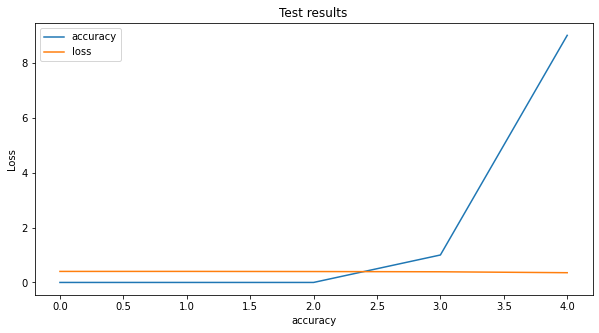

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Test results")
plt.plot(accuracy_list,label="accuracy")
plt.plot(loss_list,label="loss")
plt.xlabel("accuracy")
plt.ylabel("Loss")
plt.legend()
plt.show()